<h1>Focal Spot Integration</h1>
<h3>This program loads camera data from a specified .csv file for data analysis. It is meant to provide a plot of the focal spot along with horizontal and vertical lineouts. It then integrates over the plotted region and, given the input pulse energy, calculates the fluence.</h3>

<h2>Imports and Fundamental Constants</h2>
Import python packages and define commonly used physical constants

In [1]:
#Imports
from math import *
import cmath
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
import sys

#Import custom modules
from physics import *

sns.set(font_scale=2.0)
sns.set_style("ticks")
mpl.rcParams.update({'font.family': 'serif', 'font.serif':'DejaVu Serif'})

%matplotlib notebook

/home/drake/.anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Load data

Load .csv files for both the focal spot data and the background data. The focal spot data has the background subtracted from it and is then normalized and cropped to a specified size.

In [30]:
fname1 = './Focal_Spot_Data/12-17-2014_best.csv'
fname2 = './Focal_Spot_Data/Beam_Blocked.csv'

#Define Data Array
Data = np.genfromtxt(fname1,delimiter=",")
Background = np.genfromtxt(fname2,delimiter=",")

#Subtract background
Data = Data - Background

#Normalize
Data = Data/np.amax(Data)

#Find location of maximum
def max_element(A):
    r, (c, l) = max(map(lambda t: (t[0], max(enumerate(t[1]), key=lambda v: v[1])), enumerate(A)), key=lambda v: v[1][1])
    return (l, r, c)

xmax = max_element(Data)[1]
ymax = max_element(Data)[2]

#Crop data
numpixels = 60 #should be divisible by 2
Data = np.fliplr(np.rot90(np.rot90(Data[(xmax-numpixels/2):(xmax+numpixels/2),(ymax-numpixels/2):(ymax+numpixels/2)])))

/home/drake/.anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Create fit

## Plot Data

After the data is loaded, create the plots for the cropped focal spot along with vertical and horizontal lineouts.

In [31]:
PixelSize = 0.5952 #camera pixel size in um
magnification = 1 #magnfication of imaging system

ImageSize = numpixels*PixelSize/magnification

<IPython.core.display.Javascript object>


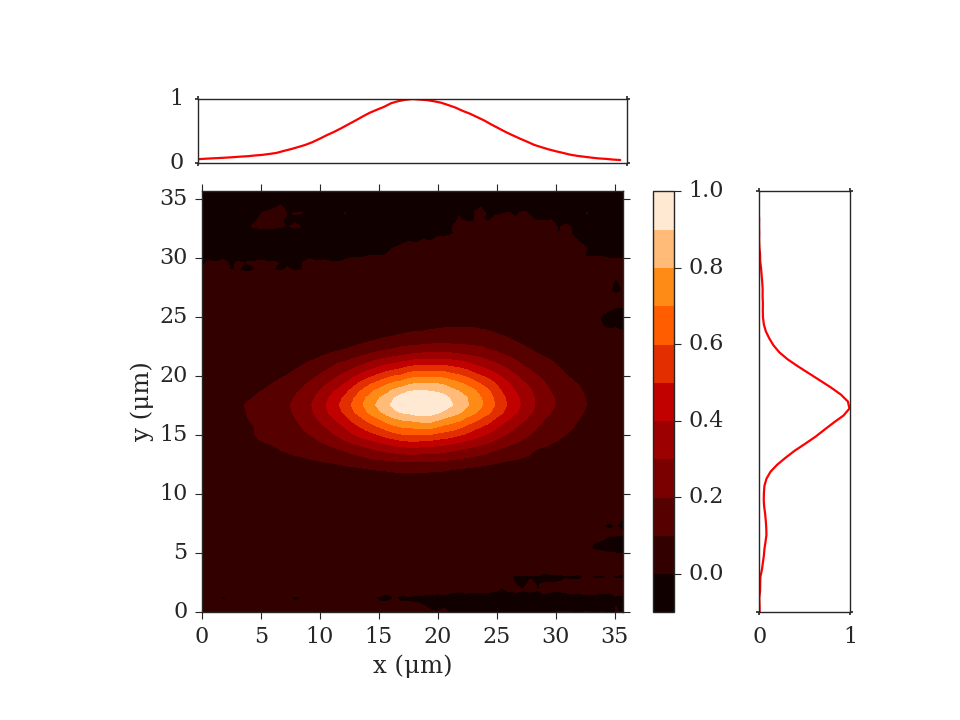

/home/drake/.anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/drake/.anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [32]:
#Create Plots

#Create figure
fig = plt.figure(figsize=(12, 9))
gs = GridSpec(100,100,bottom=0.15,left=0.15,right=0.95)
axT = fig.add_subplot(gs[5:17,7:63])
axColor = fig.add_subplot(gs[22:,0:78])
axR = fig.add_subplot(gs[22:,80:92])

#Plot data
# axColor.set_aspect('equal')
# fig.colorbar(axColor.imshow(Data, cmap='gist_heat', \
#                             extent=[0,ImageSize,0,ImageSize]),ax=axColor)
# axColor.set_xlabel('x (um)')
# axColor.set_ylabel('y (um)')

#Discrete contour version:
N = 10 #Number of levels
axColor.set_aspect('equal')
fig.colorbar(axColor.contourf(Data, N,extent=[0,ImageSize,0,ImageSize],cmap=mpl.cm.gist_heat),ax=axColor)
axColor.set_xlabel('x (μm)')
axColor.set_ylabel('y (μm)')

#Vertical lineout
position = np.array(range(len(Data)))
axR.plot(Data[:,numpixels/2-1],position, color='r', linewidth=2)
axR.set_xlim(0,1)
axR.set_ylim(0,len(Data))
axR.set_xticks([0,1])
axR.set_yticks([0,len(Data)])
axR.set_xticklabels(['0','1'])
axR.set_yticklabels('',visible=False)
axR.tick_params(axis='both',length=3,width=1.5)

#Horizontal lineout
axT.plot(position,Data[numpixels/2-1,:], color='r', linewidth=2)
axT.set_xlim(0,len(Data))
axT.set_ylim(0,1)
axT.set_xticks([0,len(Data)])
axT.set_yticks([0,1])
axT.set_yticklabels(['0','1'])
axT.set_xticklabels('',visible=False)
axT.tick_params(axis='both',length=3,width=1.5)
plt.savefig('2016_09_21_FocalSpot_Probe_Discrete.svg')

## Integrate and Plot Used Pixels

Integrate over the cropped region using the magnification and pixel size. A cut-off is used to help prevent the background from artifically lowering the fluence. The location of the pixels used to determine the peak fluence are then plotted.

For perfect Gaussian, peak fluence = 0.36663709908203745 J/cm^2
Actual peak fluence = 7.59285145318 J/cm^2
8.63970543932e-07


<IPython.core.display.Javascript object>


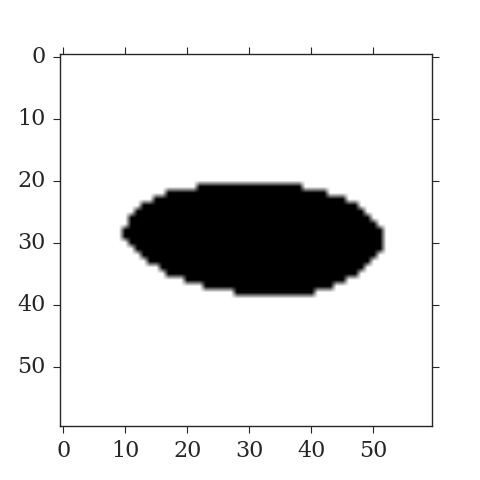

In [33]:
#Integrate data

Energy = 6.56*10**-6 #Pulse energy in J
# w0x = 389.9/sqrt(2*log(2))/magnification #x beam waist radius
# w0y = 238.4/sqrt(2*log(2))/magnification #y beam waist radius
w0x = 33.75 #x beam waist radius
w0y = 33.75 #y beam waist radius

ChosenPixels = [[0 for i in range(len(Data))] for j in range(len(Data))]
CutOff = exp(-2)
Integral = 0
for i in range(len(Data)):
    for j in range(len(Data)):
        if Data[i,j]>CutOff:
            Integral += Data[i,j]*(PixelSize*10**-4/magnification)**2
            ChosenPixels[i][j] = 1

# print('For perfect Gaussian, peak fluence =',2*Energy/(pi*w0x*w0y*(PixelSize/magnification)**2),'J/cm^2')
print('For perfect Gaussian, peak fluence =',2*Energy*10**6/(pi*w0x*w0y)*100,'J/cm^2')
        
PeakFluence = Energy/Integral
print('Actual peak fluence =',PeakFluence,'J/cm^2')
print(Integral)

#Plot used pixels
fig, ax = plt.subplots(figsize=(6, 6))

#Plot data
im = ax.imshow(ChosenPixels, cmap=mpl.cm.Greys)